In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
from tqdm.auto import tqdm

from utils import (
    fit_exp,
)

In [2]:
yahist.utils.set_default_style()

In [3]:
# data before 1point3acres stopped providing the blurbs and links for each set of new cases :(
fname = "../sources/1point3acres/data/cases_and_deaths_with_links.json.gz"
df_total = pd.read_json(fname)
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total.sort_values(["date"])

# drop cruise ship stuff
df_total = df_total[
    (df_total["state"].str.len() == 2)
    & (df_total["county"].str.strip().str.len() > 0)
]

df_total["place"] = df_total["county"].str.cat(df_total["state"], sep=", ")

df_deaths = df_total.query("is_death").reset_index(drop=True)
df_cases = df_total.query("not is_death").reset_index(drop=True)

# total cases, so no deaths
df_counties = df_cases.groupby(["date","place"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()
df_states = df_cases.groupby(["date","state"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()

In [4]:
age_mapping = {
    "0-9"  : ["<10"], 
    "10-19": ["10+", "teens"], 
    "20-29": ["20+", "20s", "twenties"], 
    "30-39": ["30+", "30s", "thirties"], 
    "40-49": ["40+", "40s", "forties"], 
    "50-59": ["50+", "50s", "fifties"], 
    "60-69": ["60+", "60s", "sixties"], 
    "70-79": ["70+", "70s", "seventies"], 
    "80-89": ["80+", "80s", "eightees"], 
    "90-99": ["90+", "90s", "nineties"], 
}
age_mapping_inv = dict()
for k,v in age_mapping.items():
    for vv in v: 
        age_mapping_inv[vv] = k
        
def convert_value(x):
    res = age_mapping_inv.get(x, None)
    if res: return res
    if x == "Unknown" or type(x) not in (str, bytes): return "Unknown"
    if "-" in x:
        low, high = x.split("-")
        middle = 0.5*(int(low) + int(high))
    else:
        middle = int(x)
    tens = int(middle / 10)*10
    return f"{tens}-{tens+9}"

def get_age_df(df):
    df = df.query("ngroup==1").copy()
    df["age1"] = df["age"].str.strip()
    df["age2"] = df["description"].str.extract("([0-9\-]+).year[s]?.old").iloc[:,-1]
    df["age3"] = df["description"].str.extract(" in (his|her) ([\w]+s)").iloc[:,-1]
    df[["age1","age2","age3"]] = df[["age1","age2","age3"]].fillna("Unknown")

    ages = []
    for i,entry in df.iterrows():
        age1 = convert_value(entry["age1"])
        age2 = convert_value(entry["age2"])
        age3 = convert_value(entry["age3"])
        if age1 != "Unknown": ages.append(age1)
        elif age2 != "Unknown": ages.append(age2)
        elif age3 != "Unknown": ages.append(age3)
        else: ages.append("Unknown")
    df["age"] = ages
    return df[df["age"] != "Unknown"]


In [5]:
df = pd.DataFrame()
df["cases"] = get_age_df(df_cases)["age"].value_counts()
df["deaths"] = get_age_df(df_deaths)["age"].value_counts()
df = df.fillna(0).sort_index()

Text(0.5, 0, 'age')

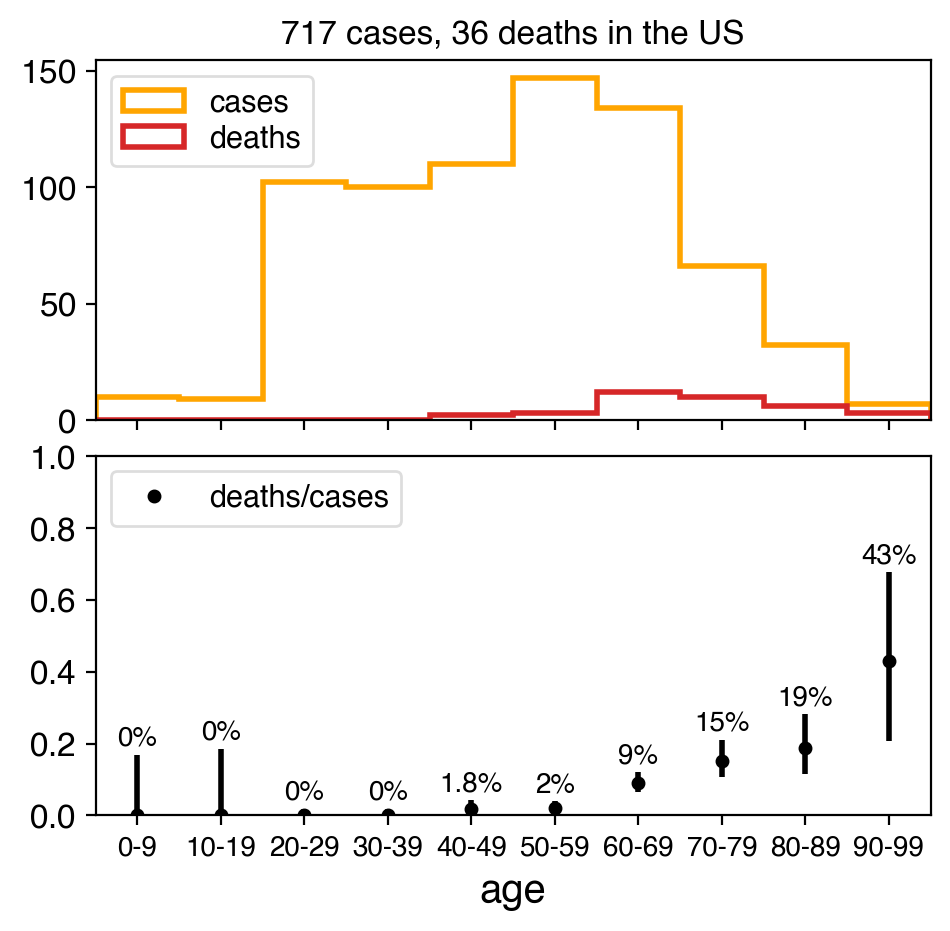

In [6]:
numer = Hist1D.from_bincounts(df["deaths"].values, np.arange(len(df)+1))
denom = Hist1D.from_bincounts(df["cases"].values, np.arange(len(df)+1))

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(5,5))
denom.plot(ax=ax1, color="orange", histtype="step", lw=2, label="cases")
numer.plot(ax=ax1, color="C3", histtype="step", lw=2, label="deaths")

ratio = numer.divide(denom, binomial=True)
ax2.plot(ratio.bin_centers, ratio.counts, color="k", linestyle="none", marker="o", markersize=4.0, label="deaths/cases")
ax2.errorbar(ratio.bin_centers, ratio.counts, yerr=[np.nan_to_num(ratio.errors_down),ratio.errors_up], linestyle="none", color="k", lw=2)

plt.xticks(np.arange(len(ratio.counts))+0.5)
ax2.set_xticklabels(df.index.values, fontsize=10);

# ax2.grid()

for x,y,yup in zip(ratio.bin_centers, ratio.counts, ratio.errors_up):
    ax2.text(x, y+yup+0.025, "{:.2g}%".format(100*y), ha="center", fontsize=10)
ax2.set_ylim([0,1.00])

ax1.set_title(f"{denom.integral:.0f} cases, {numer.integral:.0f} deaths in the US")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax2.set_xlabel("age")

Text(0, 0.5, 'Fraction of male cases')

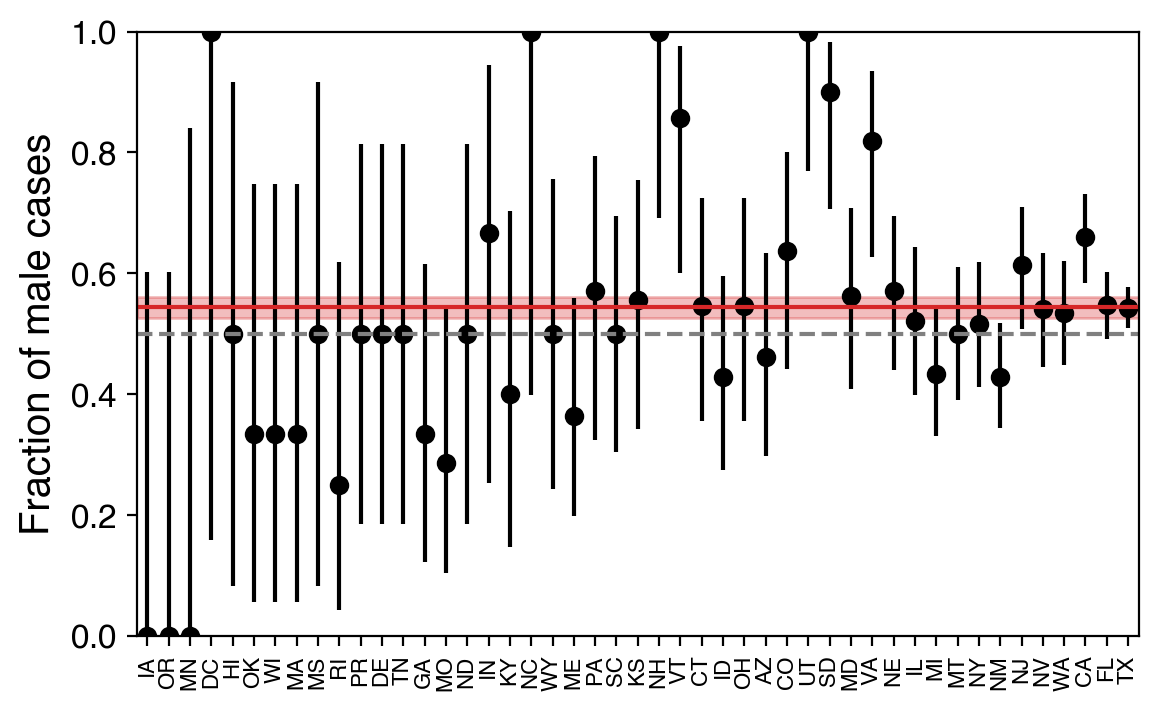

In [7]:
df = df_cases.query("ngroup==1")

f = df.groupby("state").apply(lambda x: (x["gender"]=="F").sum())
m = df.groupby("state").apply(lambda x: (x["gender"]=="M").sum())
numer, denom = m, f+m
mask = (denom > 0)
numer = numer[mask]
denom = denom[mask]
ratio = numer/denom

from yahist.utils import clopper_pearson_error
lows, highs = clopper_pearson_error(numer, denom)

df = pd.DataFrame()
df["state"] = numer.index
df["numer"] = numer.values
df["denom"] = denom.values
df["ratio"] = ratio.values
df["lows"] = lows
df["highs"] = highs
df = df.set_index("state").sort_values("numer")

fig, ax = plt.subplots()
xs = np.arange(len(df["ratio"]))
ys = df["ratio"]
# ups = 
downs = np.nan_to_num(ys - df["lows"])
ups = np.nan_to_num(df["highs"] - ys)
ax.plot(xs, ys, color="k", marker="o", lw=0)
ax.errorbar(xs, ys, yerr=(downs, ups), linestyle="none", color="k")

ax.set_xlim([
    ax.get_xlim()[0]-0.5,
    ax.get_xlim()[1]+0.5,
])

totnumer, totdenom = df["numer"].sum(), df["denom"].sum()
totratio = totnumer/totdenom
low, high = clopper_pearson_error(totnumer, totdenom)
# fig, ax = plt.subplots()
ax.plot(ax.get_xlim(), [totratio, totratio], color="C3")
ax.fill_between(ax.get_xlim(), y1=[low, low], y2=[high, high], color="C3", alpha=0.3)

ax.plot(ax.get_xlim(), [0.5, 0.5], color="gray", linestyle="--")

plt.xticks(xs, df.index, rotation=90, fontsize=8);
ax.set_ylim([0, 1])

ax.set_ylabel("Fraction of male cases")